In [60]:
import os
import torch
from torch import nn
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using: {device}")

Using: cpu


In [61]:
from pathlib import Path
data = Path('data/')
train_dir = data / 'train'
test_dir = data / 'test'

In [62]:
NUM_WORKERS = os.cpu_count()

In [63]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [64]:
from data_setup import create_dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(
	train_dir=train_dir,
	test_dir=test_dir,
	transform=auto_transforms,
	batch_size=32,
	num_workers=NUM_WORKERS
)


In [65]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [66]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [67]:
for param in model.features.parameters():
	param.requires_grad = False

In [68]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [69]:
model.classifier = nn.Sequential(
	nn.Dropout(p=0.2, inplace=True),
	nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [70]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [71]:
# Loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
# Now let's train
from engine import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(
	model=model,
	train_dataloader=train_dataloader,
	test_dataloader=test_dataloader,
	loss_fn=loss_fn,
	optimizer=optimizer,
	epochs=5,
	device=device
)

end_time = timer()
print(f"[INFO] Total training tim: {end_time - start_time}.")

 20%|██        | 1/5 [01:14<04:56, 74.09s/it]

Epoch: 1 | train_loss: 0.6527 | train_acc: 0.7500 | test_loss: 0.6790 | test_acc: 0.6667 | 


 40%|████      | 2/5 [01:30<02:00, 40.07s/it]

Epoch: 2 | train_loss: 0.6210 | train_acc: 0.8000 | test_loss: 0.6578 | test_acc: 1.0000 | 


 60%|██████    | 3/5 [01:46<00:58, 29.19s/it]

Epoch: 3 | train_loss: 0.5424 | train_acc: 0.8000 | test_loss: 0.6367 | test_acc: 1.0000 | 


 80%|████████  | 4/5 [02:02<00:23, 23.98s/it]

Epoch: 4 | train_loss: 0.4853 | train_acc: 0.9500 | test_loss: 0.6222 | test_acc: 1.0000 | 


100%|██████████| 5/5 [02:18<00:00, 27.72s/it]

Epoch: 5 | train_loss: 0.4658 | train_acc: 1.0000 | test_loss: 0.6117 | test_acc: 0.8333 | 
[INFO] Total training tim: 138.62810049997643.


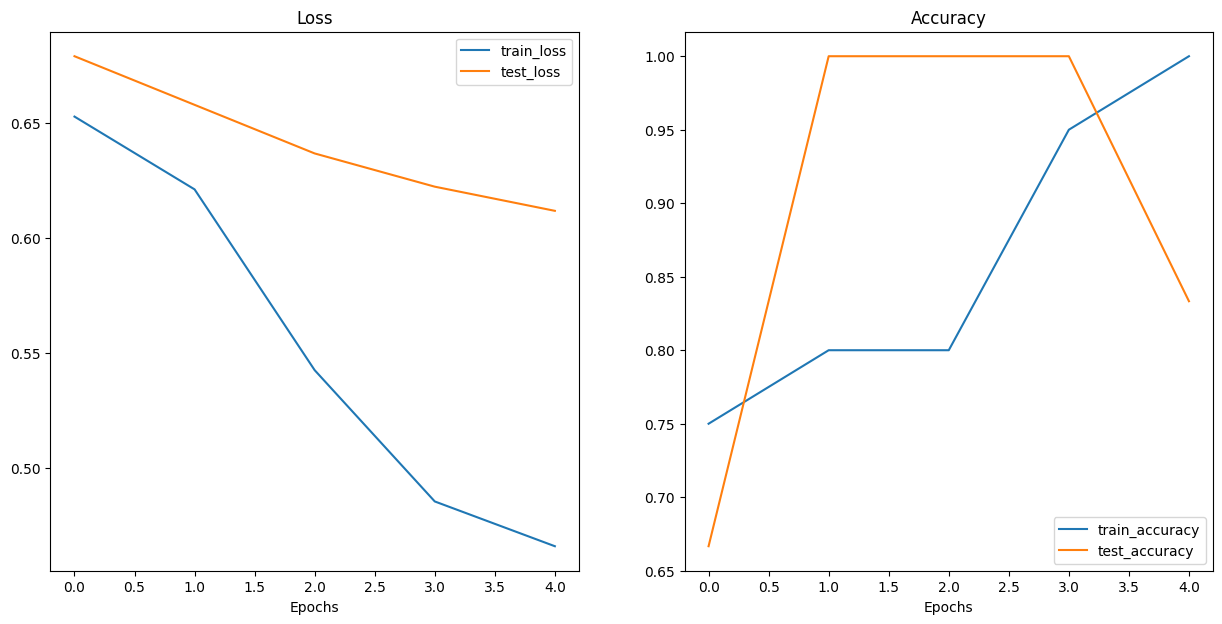

In [73]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [76]:
# Pred and plot function

from typing import List, Tuple
from PIL import Image

def pred_and_plot(
	model: torch.nn.Module,
	image_path: str,
	class_names: List[str] = class_names,
	image_size: Tuple[int, int] = (224, 224),
	transform: torchvision.transforms = None,
	device: torch.device=device
):
	image = Image.open(image_path).convert('RGB')

	if transform is not None:
		image_transform = transform
	else:
		transform = torchvision.transforms.Compose([
			torchvision.transforms.Resize(image_size),
			torchvision.transforms.ToTensor(),
			torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
		])
		image_transform = transform
	
	model.to(device)

	model.eval()
	with torch.inference_mode():
		# Forward pass
		transformed_image = image_transform(image).unsqueeze(dim=0)

		target_image_pred = model(transformed_image)

	target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
	target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

	plt.figure()
	plt.imshow(image)
	plt.title(f"Prediction: {class_names[target_image_pred_label]} | Probability: {target_image_pred_probs.max()} %")


TypeError: only integer tensors of a single element can be converted to an index

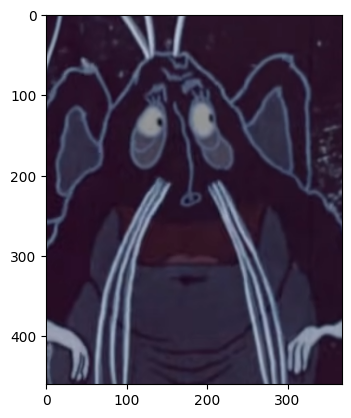

In [77]:
pred_and_plot(
	model=model,
	image_path="./Byuzand.png",
	class_names=class_names,
	image_size=(224, 224),
	device=device
)